In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader, random_split
from google.colab import drive

# **DATA UNDERSTANDING**

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
weather = pd.read_csv('/content/drive/MyDrive/weather_prediction_dataset.csv')

In [ ]:
weather

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,20091228,12,7,0.82,1.0084,0.28,0.42,0.3,3.2,1.0,...,-2.7,2.4,3.7,0.95,1.0011,0.22,1.50,6.2,1.8,10.6
3650,20091229,12,7,0.92,1.0028,0.22,1.68,0.2,4.5,2.4,...,-9.5,0.8,5.3,0.89,0.9966,0.24,0.40,10.4,6.2,14.5
3651,20091230,12,8,0.92,0.9979,0.07,1.54,0.0,8.5,7.5,...,-12.5,-7.4,3.8,0.88,0.9939,0.24,1.00,10.0,8.7,11.3
3652,20091231,12,7,0.93,0.9958,0.17,0.57,0.1,6.6,4.3,...,-9.3,-6.5,4.2,0.88,0.9933,0.58,0.02,8.5,6.2,10.9


In [ ]:
weather.columns = [col.replace("_", "").lower().strip() for col in weather.columns]

features = [
    'cloudcover', 'windspeed', 'windgust', 'humidity', 'pressure', 'globalradiation',
    'precipitation', 'sunshine', 'tempmean', 'tempmin', 'tempmax'
]

kota_fitur = {}
for col in weather.columns:
    for feature in features:
        if col.endswith(feature):
            kota = col.replace(feature, "")
            if kota not in kota_fitur:
                kota_fitur[kota] = set()
            kota_fitur[kota].add(feature)
            break

kota_lengkap = [kota for kota, fitur_set in kota_fitur.items() if all(f in fitur_set for f in features)]

kota_tidak_lengkap = {}
for kota, fitur_set in kota_fitur.items():
    if kota not in kota_lengkap:
        fitur_kurang = [f for f in features if f not in fitur_set]
        kota_tidak_lengkap[kota] = fitur_kurang

kolom_kota_lengkap = [col for col in weather.columns if any(col.startswith(kota) for kota in kota_lengkap)]

df_kota_lengkap = weather[kolom_kota_lengkap]

print("Kota dengan fitur lengkap:")
print(kota_lengkap)

print("\nKota yang fiturnya tidak lengkap dan fitur yang hilang:")
for kota, fitur_kurang in kota_tidak_lengkap.items():
    print(f"- {kota}: kurang {fitur_kurang}")

Kota dengan fitur lengkap:
['debilt', 'dusseldorf', 'maastricht', 'muenchen', 'oslo']

Kota yang fiturnya tidak lengkap dan fitur yang hilang:
- basel: kurang ['windspeed', 'windgust']
- budapest: kurang ['windspeed', 'windgust', 'tempmin']
- dresden: kurang ['pressure']
- heathrow: kurang ['windspeed', 'windgust']
- kassel: kurang ['cloudcover']
- ljubljana: kurang ['windgust']
- malmo: kurang ['cloudcover', 'windgust', 'humidity', 'pressure', 'globalradiation', 'sunshine']
- montelimar: kurang ['cloudcover', 'windgust', 'sunshine']
- perpignan: kurang ['cloudcover', 'windgust', 'sunshine']
- roma: kurang ['windspeed', 'windgust', 'precipitation']
- sonnblick: kurang ['windspeed', 'windgust', 'pressure']
- stockholm: kurang ['windspeed', 'windgust', 'humidity', 'globalradiation']
- tours: kurang ['cloudcover', 'windgust', 'sunshine']


In [ ]:
# Filter kolom yang berasal dari kota selain 'debilt'
kolom_kota_lengkap = [
    col for col in weather.columns
    if any(col.startswith(kota) for kota in kota_lengkap) and not col.startswith('debilt')
]

# Subset DataFrame hanya dengan kolom dari kota lengkap (tanpa debilt)
df_kota_lengkap = weather[kolom_kota_lengkap]

# Tambahkan kolom date jika tersedia
if 'date' in weather.columns:
    df_kota_lengkap = df_kota_lengkap.copy()  # hindari SettingWithCopyWarning
    df_kota_lengkap['date'] = weather['date']
    kolom_urut = ['date'] + kolom_kota_lengkap
    df_kota_lengkap = df_kota_lengkap[kolom_urut]

# Simpan ke CSV
df_kota_lengkap.to_csv('kota_lengkap.csv', index=False)

In [ ]:
cuaca = pd.read_csv('kota_lengkap.csv')

In [ ]:
cuaca

,date,dusseldorfcloudcover,dusseldorfwindspeed,dusseldorfwindgust,dusseldorfhumidity,dusseldorfpressure,dusseldorfglobalradiation,dusseldorfprecipitation,dusseldorfsunshine,dusseldorftempmean,...,oslowindspeed,oslowindgust,oslohumidity,oslopressure,osloglobalradiation,osloprecipitation,oslosunshine,oslotempmean,oslotempmin,oslotempmax
0,20000101,8,2.5,5.9,0.92,1.0240,0.12,0.22,0.0,4.2,...,0.9,5.1,0.94,1.0130,0.04,0.60,0.0,-5.0,-8.6,-3.2
1,20000102,6,3.0,7.4,0.87,1.0283,0.19,0.00,0.7,6.5,...,1.9,5.7,0.94,1.0076,0.11,0.00,1.6,-0.8,-6.7,2.4
2,20000103,7,5.5,14.3,0.78,1.0235,0.12,0.28,0.0,7.7,...,1.7,8.7,0.88,1.0016,0.04,0.00,0.0,1.2,-1.1,3.8
3,20000104,7,6.0,16.8,0.87,1.0162,0.12,0.97,0.0,7.8,...,3.4,11.8,0.58,0.9982,0.13,0.00,5.3,2.1,-0.5,5.1
4,20000105,4,4.5,11.2,0.80,1.0203,0.51,0.00,6.5,5.2,...,1.2,5.7,0.94,1.0055,0.05,0.06,0.0,-0.7,-4.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,20091228,7,3.7,11.5,0.91,1.0050,0.11,0.04,0.0,3.4,...,1.2,5.3,0.88,0.9954,0.16,0.00,4.8,-10.1,-11.7,-5.9
3650,20091229,6,3.0,9.8,0.88,0.9998,0.16,1.57,0.4,2.2,...,0.7,4.1,0.88,1.0060,0.16,0.00,4.9,-13.1,-15.1,-9.1
3651,20091230,8,2.2,6.5,0.99,0.9925,0.11,0.90,0.0,4.8,...,0.6,3.5,0.85,1.0094,0.16,0.00,4.4,-15.7,-17.5,-11.8
3652,20091231,8,3.1,6.3,0.97,0.9949,0.11,0.04,0.0,0.6,...,0.6,2.4,0.88,1.0062,0.11,0.02,1.7,-10.8,-16.8,-8.9


In [ ]:
print("Info Dataset:")
print(cuaca.info())

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       3654 non-null   int64  
 1   dusseldorfcloudcover       3654 non-null   int64  
 2   dusseldorfwindspeed        3654 non-null   float64
 3   dusseldorfwindgust         3654 non-null   float64
 4   dusseldorfhumidity         3654 non-null   float64
 5   dusseldorfpressure         3654 non-null   float64
 6   dusseldorfglobalradiation  3654 non-null   float64
 7   dusseldorfprecipitation    3654 non-null   float64
 8   dusseldorfsunshine         3654 non-null   float64
 9   dusseldorftempmean         3654 non-null   float64
 10  dusseldorftempmin          3654 non-null   float64
 11  dusseldorftempmax          3654 non-null   float64
 12  maastrichtcloudcover       3654 non-null   int64  
 13  maastrichtwindspeed        3654 no

In [ ]:
print("Statistik Deskriptif:")
print(cuaca.describe())

Statistik Deskriptif:
               date  dusseldorfcloudcover  dusseldorfwindspeed  \
count  3.654000e+03           3654.000000          3654.000000   
mean   2.004568e+07              5.141762             3.963738   
std    2.874287e+04              2.115639             1.718106   
min    2.000010e+07              0.000000             1.000000   
25%    2.002070e+07              4.000000             2.600000   
50%    2.004567e+07              6.000000             3.700000   
75%    2.007070e+07              7.000000             5.000000   
max    2.010010e+07              8.000000            12.200000   

       dusseldorfwindgust  dusseldorfhumidity  dusseldorfpressure  \
count         3654.000000         3654.000000         3654.000000   
mean            10.591680            0.755744            1.016000   
std              3.884296            0.111595            0.009302   
min              2.800000            0.260000            0.975900   
25%              7.800000            0

# **EDA**

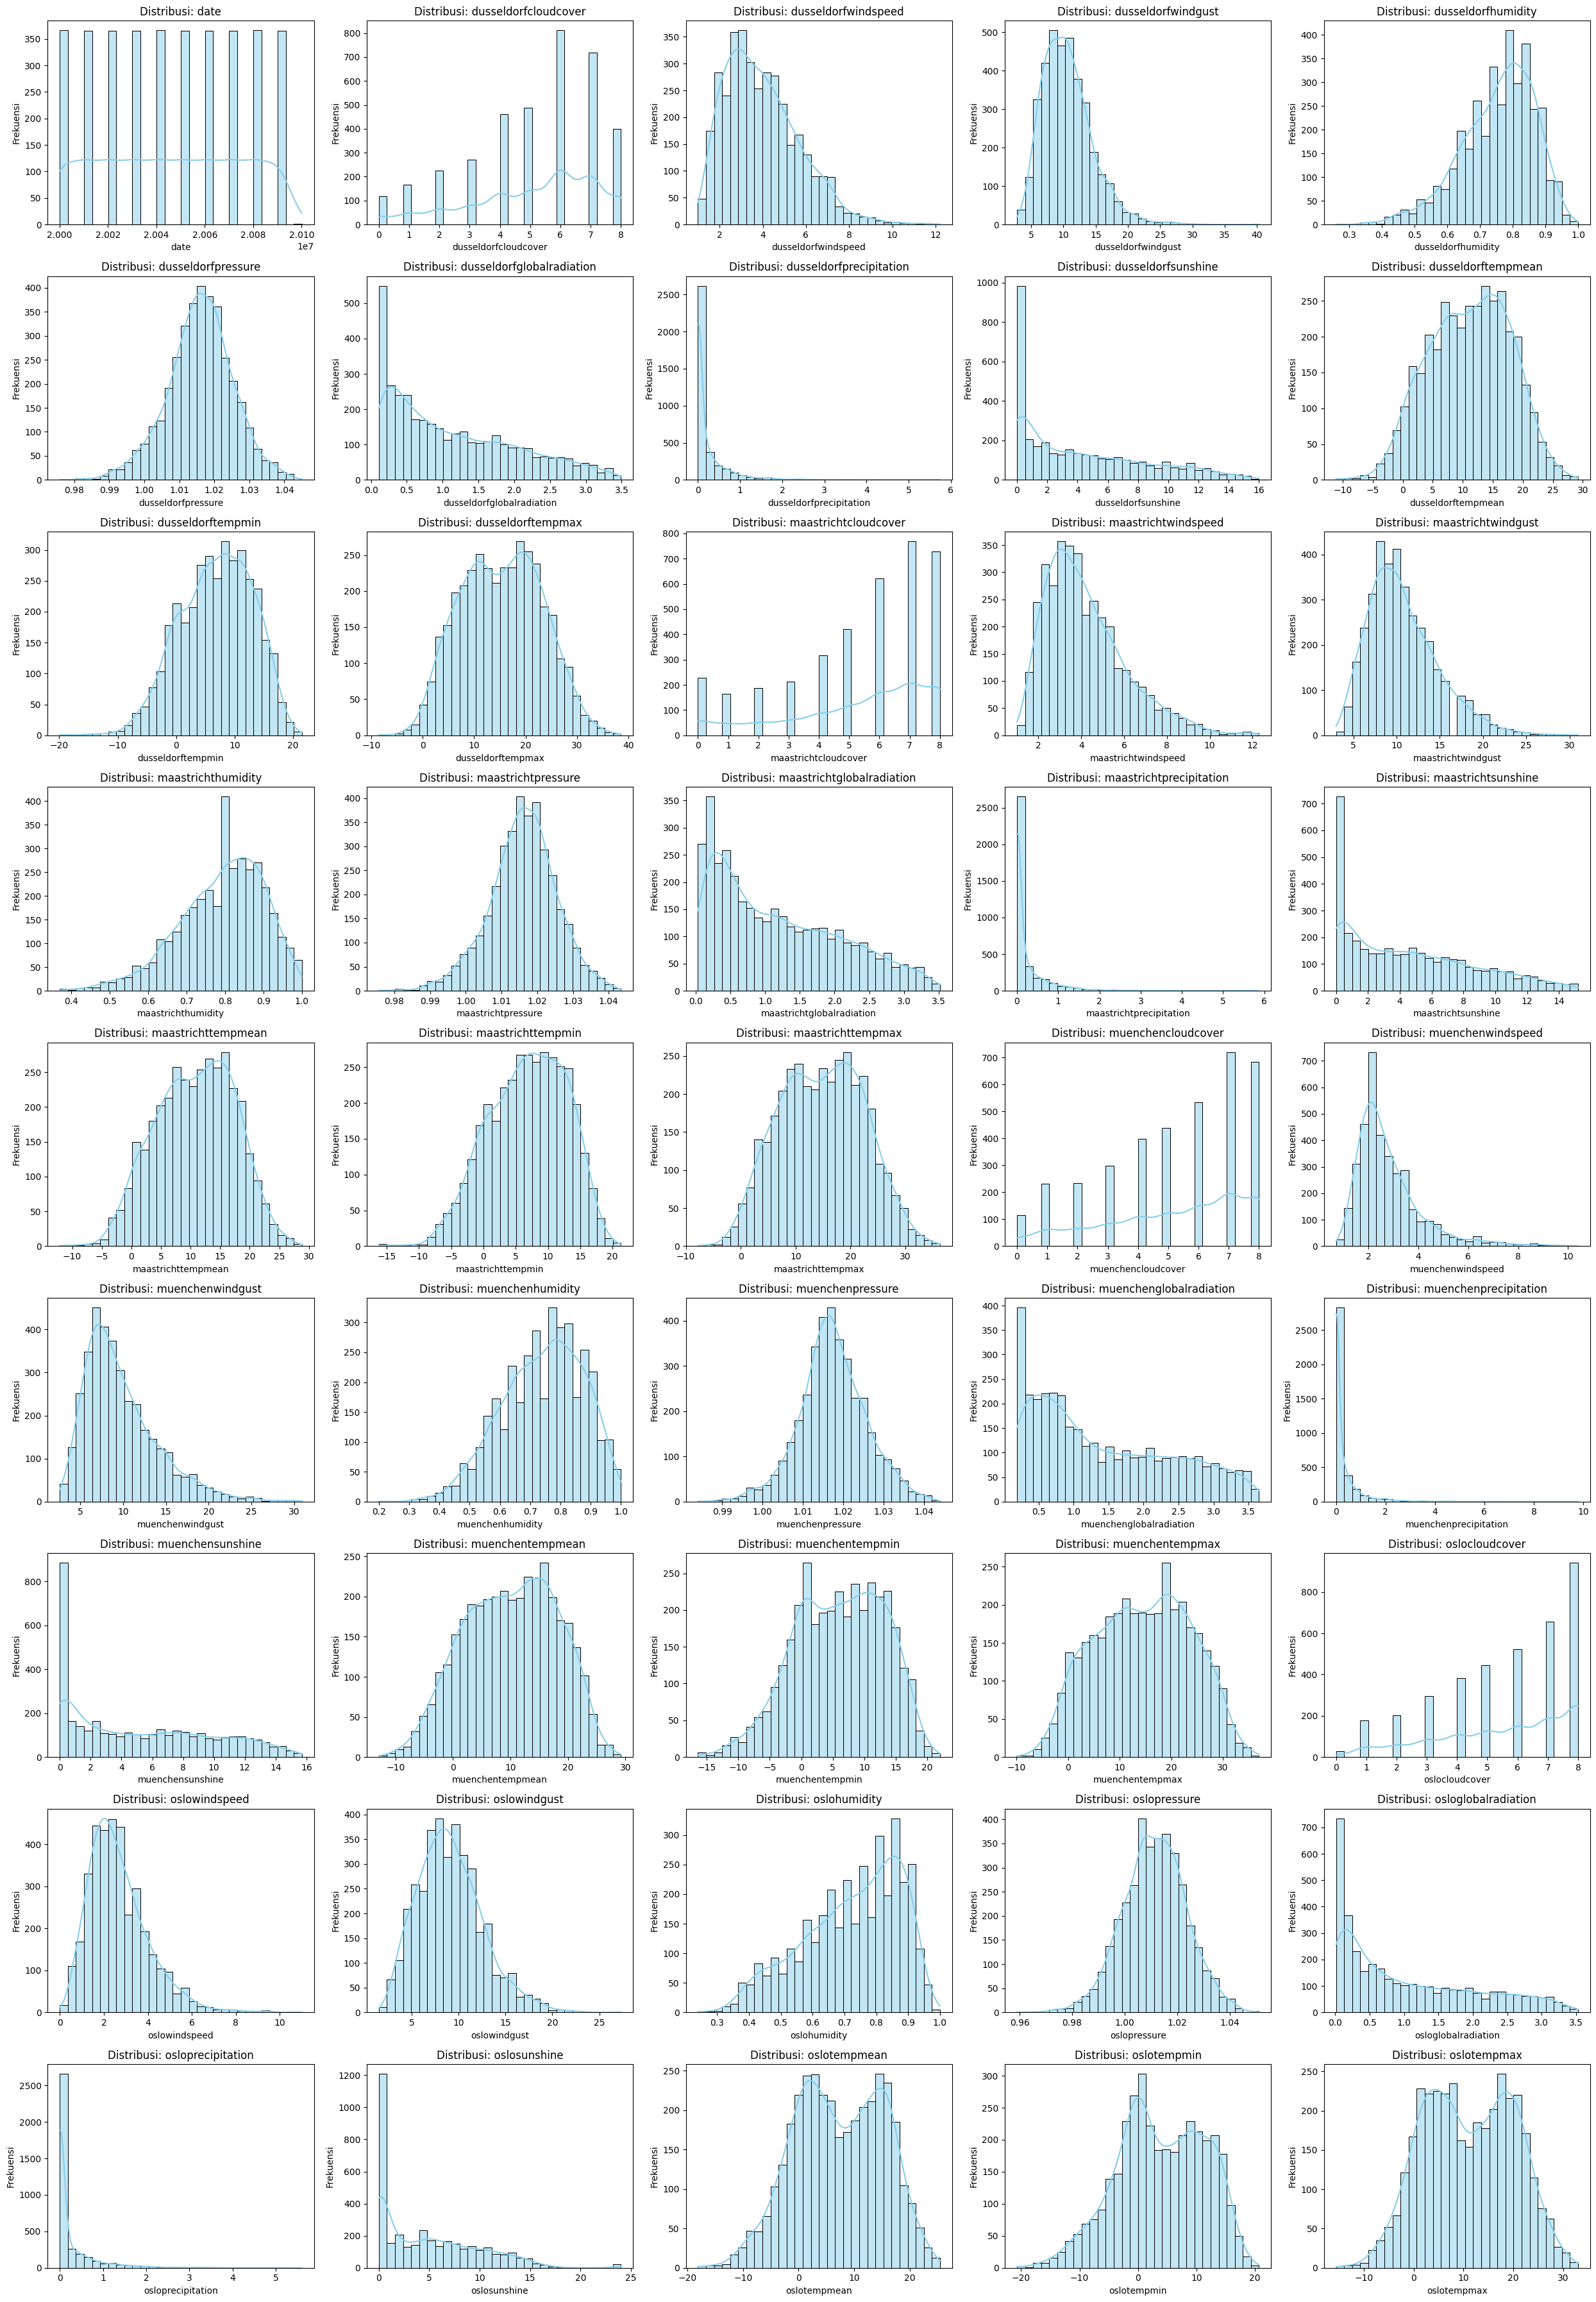

In [ ]:
numerical_cols = cuaca.select_dtypes(include='number').columns
ncols = 5
nrows = math.ceil(len(numerical_cols) / ncols)
plt.figure(figsize=(ncols * 5, nrows * 4))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(nrows, ncols, i)
    sns.histplot(cuaca[col].dropna(), kde=True, bins=30, color='skyblue')
    plt.title(f"Distribusi: {col}")
    plt.xlabel(col)
    plt.ylabel("Frekuensi")

plt.tight_layout()
plt.show()


Missing Values per Kolom:
Series([], dtype: int64)


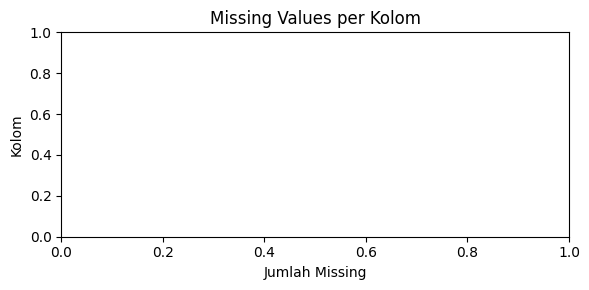

In [ ]:
missing = cuaca.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

print("\nMissing Values per Kolom:")
print(missing)

plt.figure(figsize=(6,3))
sns.barplot(x=missing.values, y=missing.index, palette='Reds_r')
plt.title("Missing Values per Kolom")
plt.xlabel("Jumlah Missing")
plt.ylabel("Kolom")
plt.tight_layout()
plt.show()

<Figure size 1600x600 with 0 Axes>

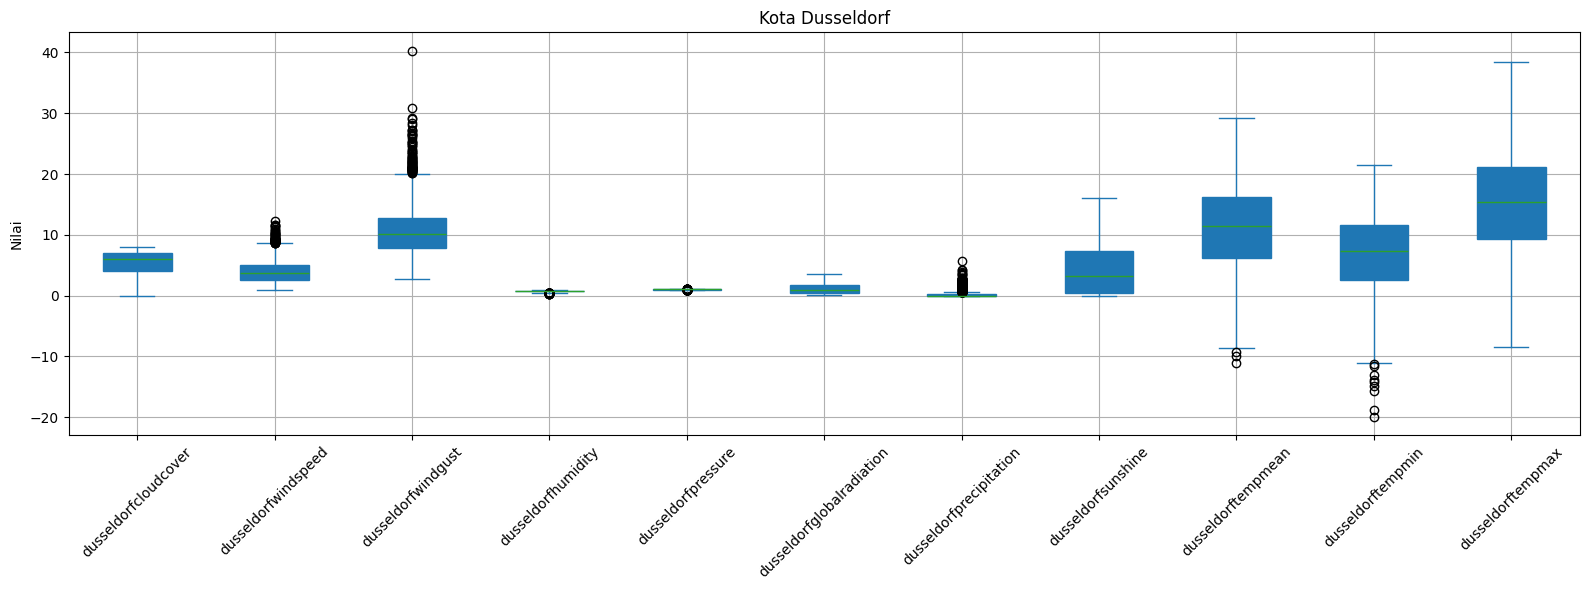

<Figure size 1600x600 with 0 Axes>

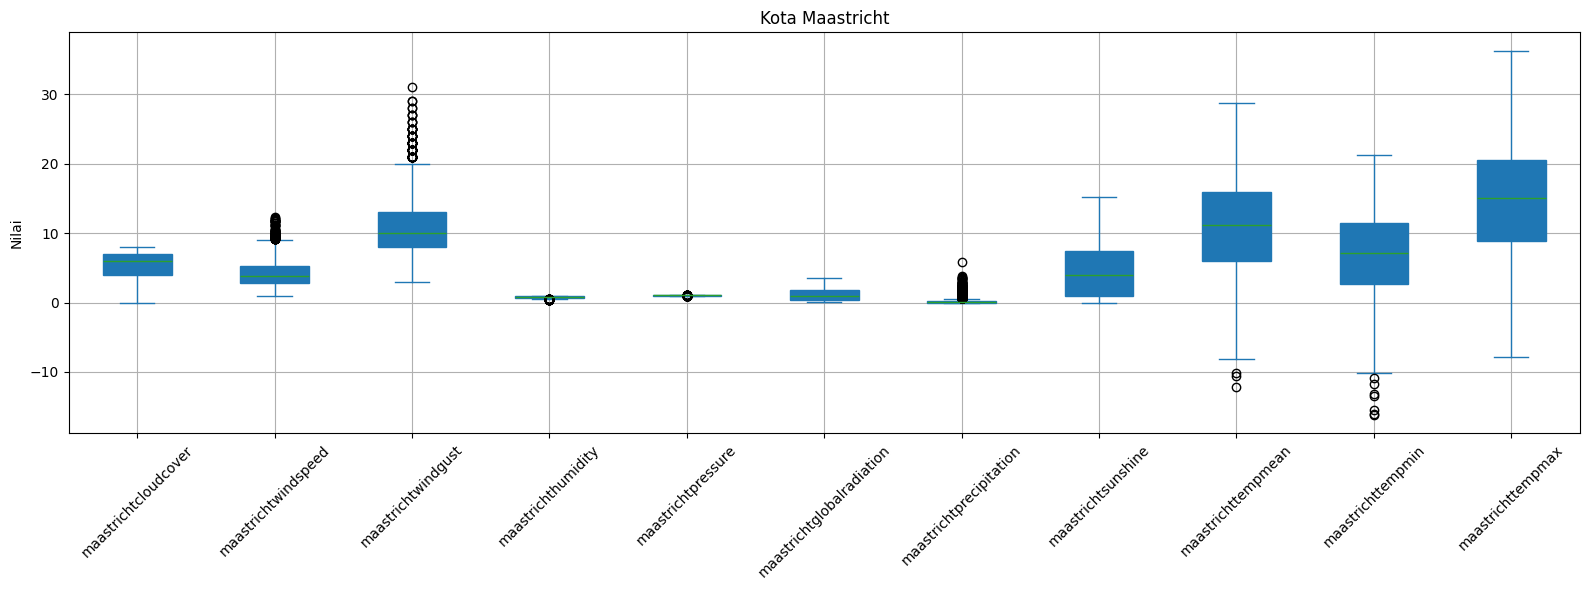

<Figure size 1600x600 with 0 Axes>

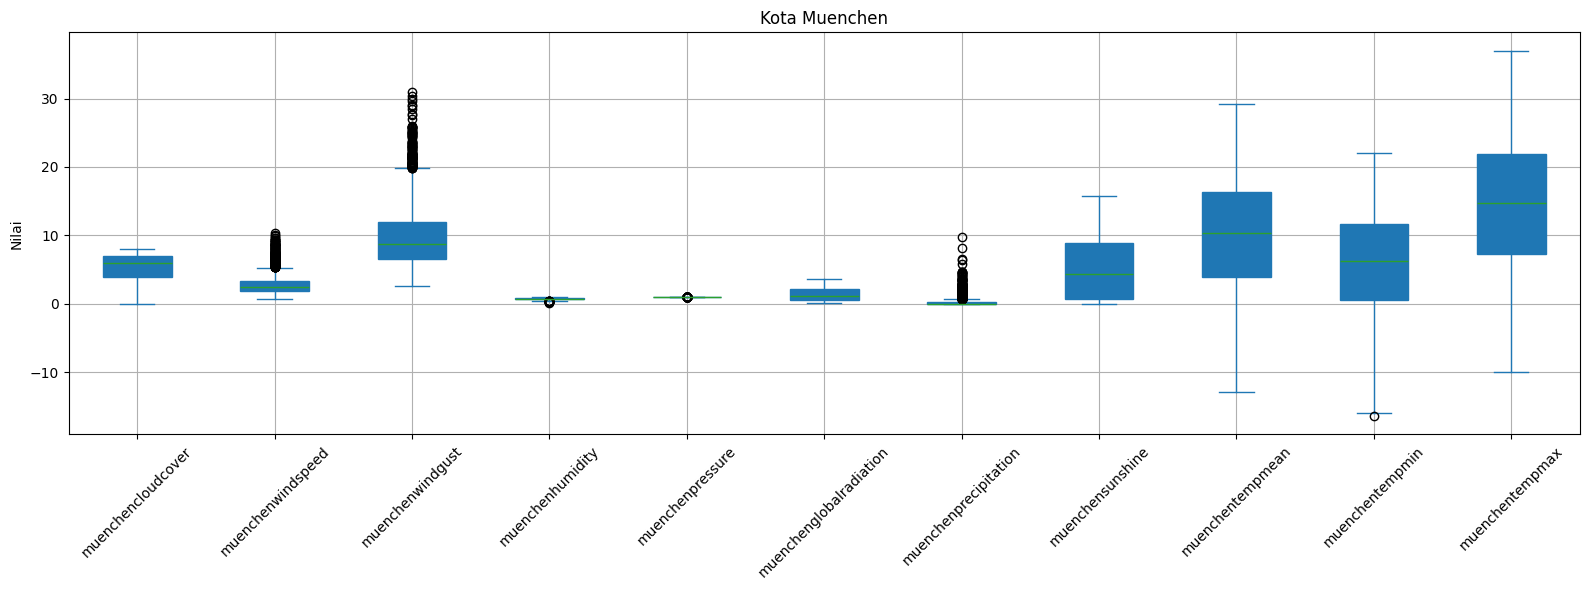

<Figure size 1600x600 with 0 Axes>

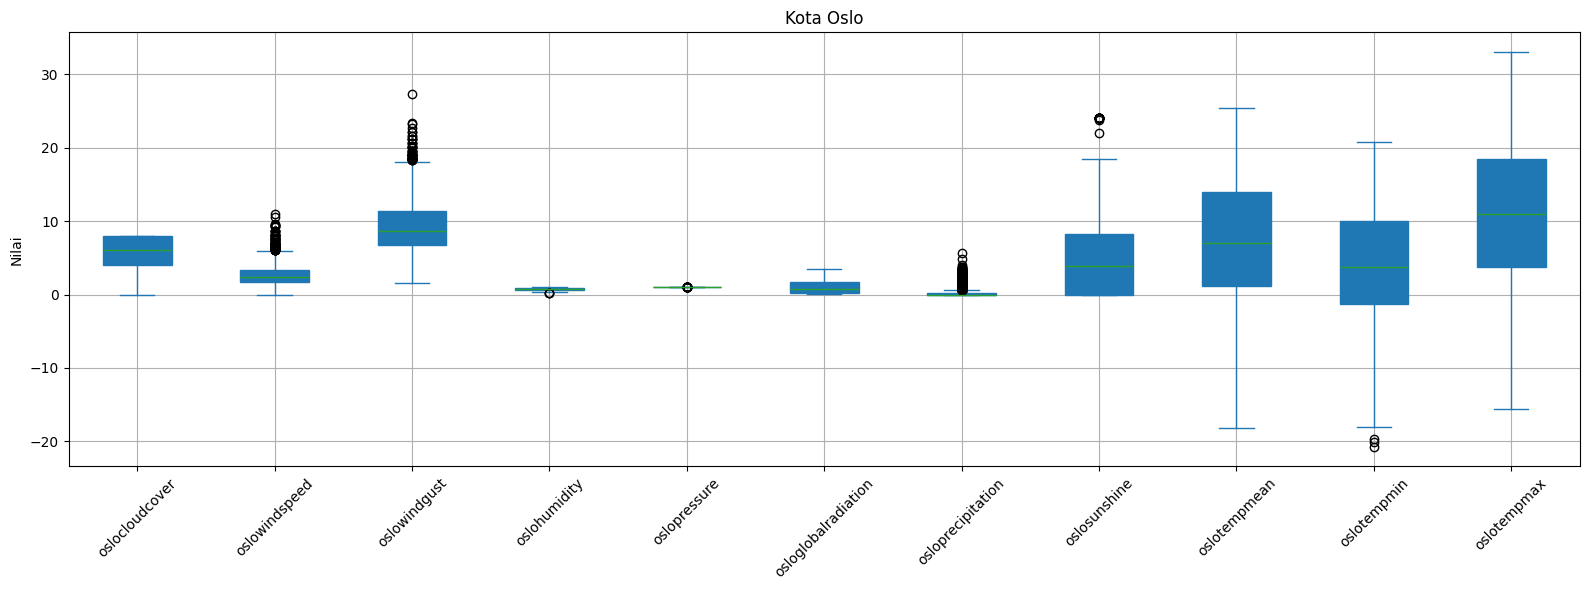

In [ ]:
kota_list = ['dusseldorf', 'maastricht', 'muenchen', 'oslo']

features = [
    'cloudcover', 'windspeed', 'windgust', 'humidity', 'pressure', 'globalradiation',
    'precipitation', 'sunshine', 'tempmean', 'tempmin', 'tempmax'
]

for kota in kota_list:
    kota_cols = [col for col in cuaca.columns if col.startswith(kota)]

    kota_cols = sorted(kota_cols, key=lambda x: features.index(x.replace(kota, "")) if x.replace(kota, "") in features else 99)

    if not kota_cols:
        continue

    plt.figure(figsize=(16, 6))
    weather[kota_cols].plot(kind='box', figsize=(16, 6), patch_artist=True)
    plt.title(f"Kota {kota.capitalize()}")
    plt.ylabel("Nilai")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

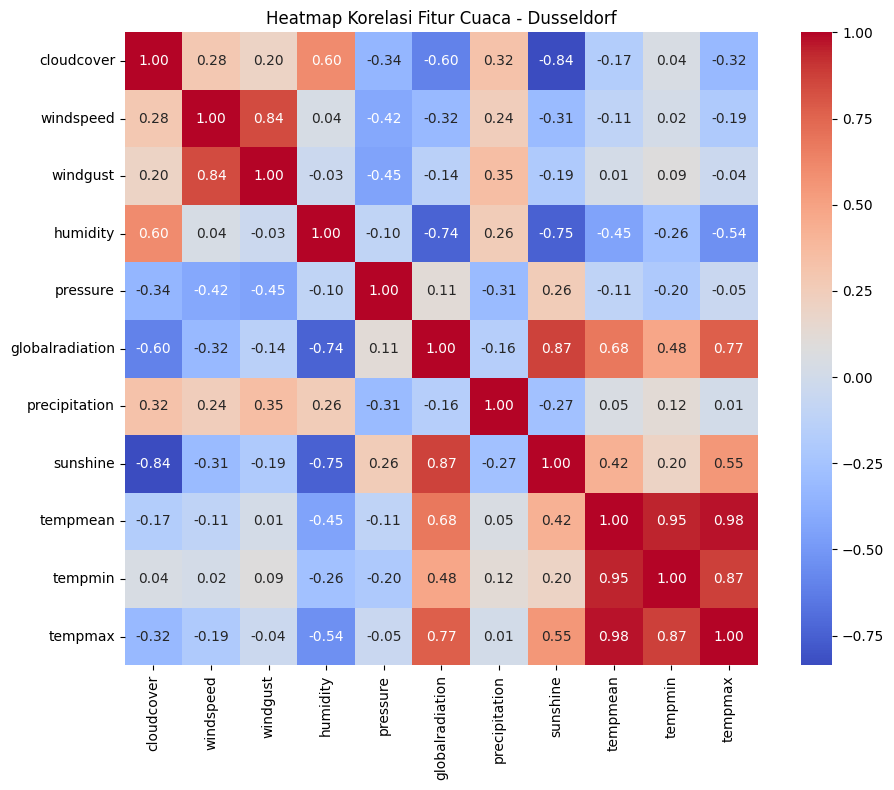

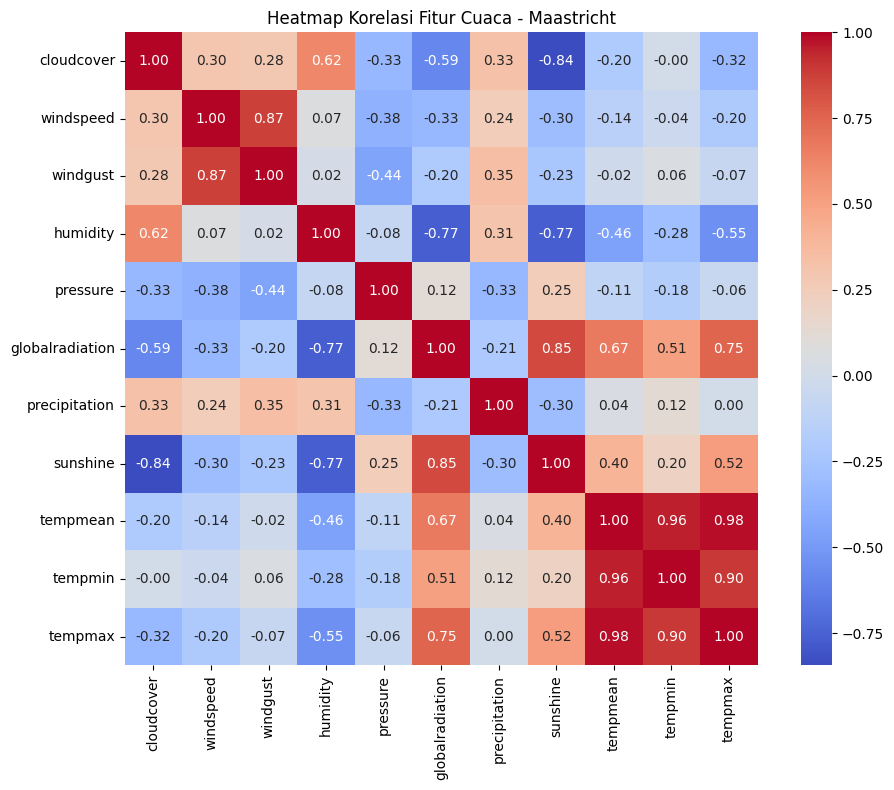

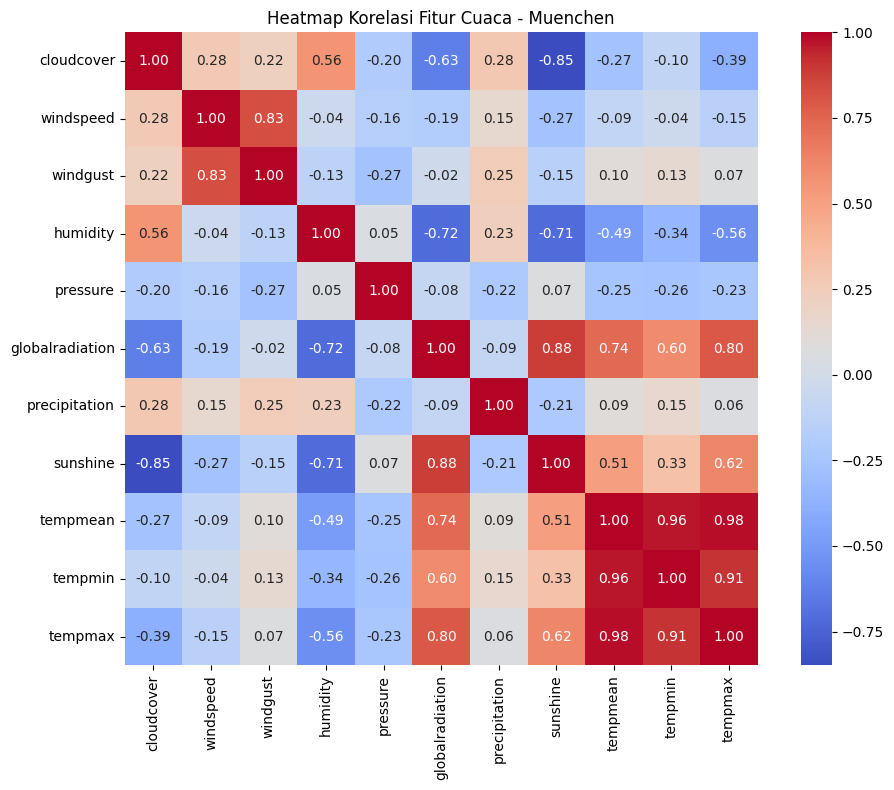

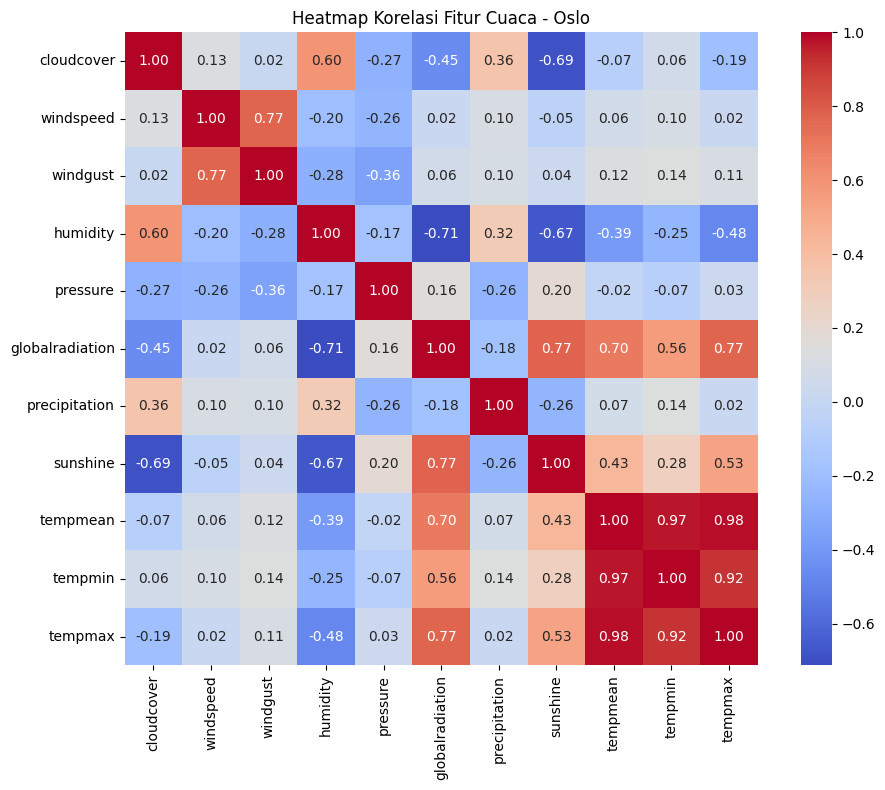

In [ ]:
kolom_fitur_kota = [f"{kota}{fitur}" for fitur in features if f"{kota}{fitur}" in cuaca.columns]

for kota in kota_list:
    kota_cols = [col for col in cuaca.columns if col.startswith(kota)]
    kota_cols = sorted(
        kota_cols,
        key=lambda x: features.index(x.replace(kota, "")) if x.replace(kota, "") in features else 99
    )
    renamed_cols = {f"{kota}{feat}": feat for feat in features if f"{kota}{feat}" in kota_cols}

    if not renamed_cols:
        continue
    df_kota = cuaca[list(renamed_cols.keys())].rename(columns=renamed_cols)
    corr = df_kota.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title(f"Heatmap Korelasi Fitur Cuaca - {kota.capitalize()}")
    plt.tight_layout()
    plt.show()


# **Pre Processing**

<ipython-input-27-e32fc6ca4415>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Fitur", y="Nilai", data=df_melt, palette="Set3")


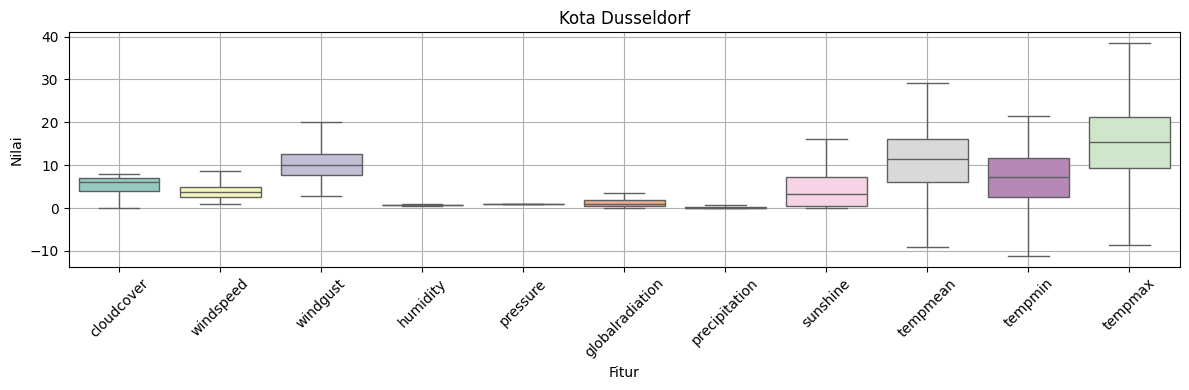

<ipython-input-27-e32fc6ca4415>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Fitur", y="Nilai", data=df_melt, palette="Set3")


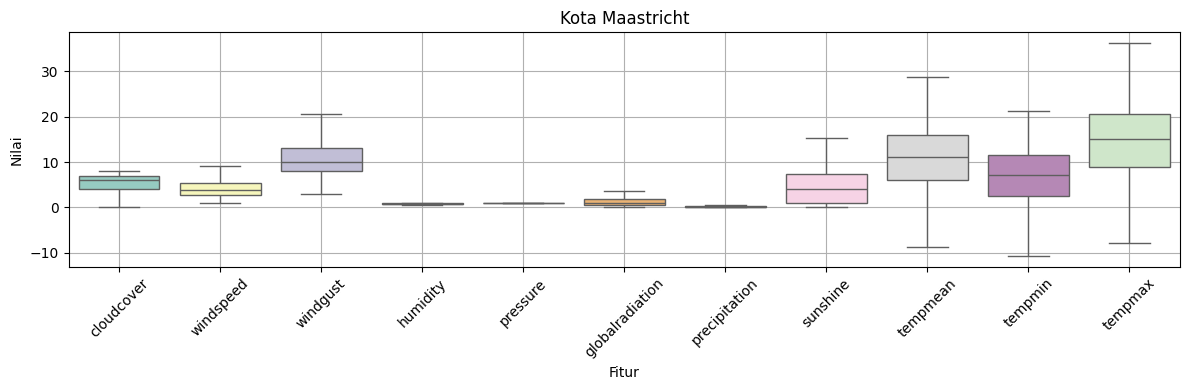

<ipython-input-27-e32fc6ca4415>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Fitur", y="Nilai", data=df_melt, palette="Set3")


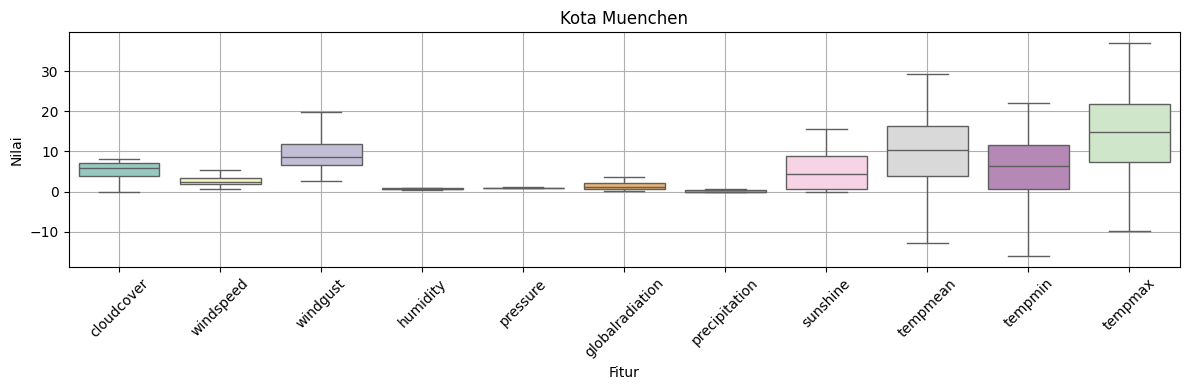

<ipython-input-27-e32fc6ca4415>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Fitur", y="Nilai", data=df_melt, palette="Set3")


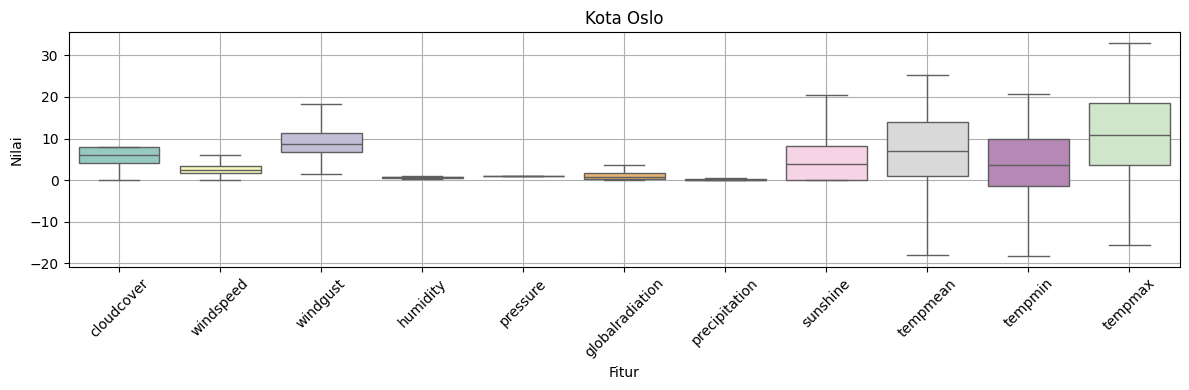

In [ ]:
kota_list = ['dusseldorf', 'maastricht', 'muenchen', 'oslo']
features = [
    'cloudcover', 'windspeed', 'windgust', 'humidity', 'pressure', 'globalradiation',
    'precipitation', 'sunshine', 'tempmean', 'tempmin', 'tempmax'
]

cuaca_outlier_handled = cuaca.copy()

def handle_outliers_column(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df[col]

for kota in kota_list:
    kota_cols = [f"{kota}{feature}" for feature in features if f"{kota}{feature}" in cuaca_outlier_handled.columns]

    for col in kota_cols:
        cuaca_outlier_handled[col] = handle_outliers_column(cuaca_outlier_handled, col)

    df_kota = cuaca_outlier_handled[kota_cols].copy()
    df_kota.columns = features
    df_melt = df_kota.melt(var_name="Fitur", value_name="Nilai")

    plt.figure(figsize=(12, 4))
    sns.boxplot(x="Fitur", y="Nilai", data=df_melt, palette="Set3")
    plt.title(f"Kota {kota.capitalize()}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [ ]:
cuaca_outlier_handled.to_csv('/content/drive/MyDrive/cuaca_bersih.csv', index=False)

In [ ]:
cb = pd.read_csv('/content/drive/MyDrive/cuaca_bersih.csv')
cb

,date,dusseldorfcloudcover,dusseldorfwindspeed,dusseldorfwindgust,dusseldorfhumidity,dusseldorfpressure,dusseldorfglobalradiation,dusseldorfprecipitation,dusseldorfsunshine,dusseldorftempmean,...,oslowindspeed,oslowindgust,oslohumidity,oslopressure,osloglobalradiation,osloprecipitation,oslosunshine,oslotempmean,oslotempmin,oslotempmax
0,20000101,8.0,2.5,5.9,0.92,1.0240,0.12,0.220,0.0,4.2,...,0.90,5.1,0.94,1.0130,0.04,0.60,0.0,-5.0,-8.6,-3.2
1,20000102,6.0,3.0,7.4,0.87,1.0283,0.19,0.000,0.7,6.5,...,1.90,5.7,0.94,1.0076,0.11,0.00,1.6,-0.8,-6.7,2.4
2,20000103,7.0,5.5,14.3,0.78,1.0235,0.12,0.280,0.0,7.7,...,1.70,8.7,0.88,1.0016,0.04,0.00,0.0,1.2,-1.1,3.8
3,20000104,7.0,6.0,16.8,0.87,1.0162,0.12,0.625,0.0,7.8,...,3.40,11.8,0.58,0.9982,0.13,0.00,5.3,2.1,-0.5,5.1
4,20000105,4.0,4.5,11.2,0.80,1.0203,0.51,0.000,6.5,5.2,...,1.20,5.7,0.94,1.0055,0.05,0.06,0.0,-0.7,-4.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,20091228,7.0,3.7,11.5,0.91,1.0050,0.11,0.040,0.0,3.4,...,1.20,5.3,0.88,0.9954,0.16,0.00,4.8,-10.1,-11.7,-5.9
3650,20091229,6.0,3.0,9.8,0.88,0.9998,0.16,0.625,0.4,2.2,...,0.70,4.1,0.88,1.0060,0.16,0.00,4.9,-13.1,-15.1,-9.1
3651,20091230,8.0,2.2,6.5,0.99,0.9933,0.11,0.625,0.0,4.8,...,0.60,3.5,0.85,1.0094,0.16,0.00,4.4,-15.7,-17.5,-11.8
3652,20091231,8.0,3.1,6.3,0.97,0.9949,0.11,0.040,0.0,0.6,...,0.60,2.4,0.88,1.0062,0.11,0.02,1.7,-10.8,-16.8,-8.9


In [ ]:
kota_list = ['dusseldorf', 'maastricht', 'muenchen', 'oslo']
fitur_umum = [
    'cloudcover', 'windspeed', 'windgust', 'humidity', 'pressure',
    'globalradiation', 'precipitation', 'sunshine', 'tempmin', 'tempmax'
]

data_per_kota = {}

for kota in kota_list:
    # Buat nama fitur dan target berdasarkan pola tanpa underscore
    fitur_kota = [f"{kota}{f}" for f in fitur_umum]
    target_kota = f"{kota}tempmean"

    # Ambil fitur, target, dan DATE dari dataframe cb
    X_kota = cb[fitur_kota]
    y_kota = cb[target_kota]
    date_kota = cb['date']  # tambahkan kolom DATE untuk sinkronisasi

    # Simpan ke dictionary
    data_per_kota[kota] = {
        "fitur": fitur_kota,
        "X": X_kota,
        "target": target_kota,
        "y": y_kota,
        "DATE": date_kota  # penting untuk keperluan klasifikasi nanti
    }

# Cek hasil untuk salah satu kota
print(data_per_kota['dusseldorf']['X'].head())
print(data_per_kota['dusseldorf']['y'].head())
print(data_per_kota['dusseldorf']['DATE'].head())


   dusseldorfcloudcover  dusseldorfwindspeed  dusseldorfwindgust  \
0                   8.0                  2.5                 5.9   
1                   6.0                  3.0                 7.4   
2                   7.0                  5.5                14.3   
3                   7.0                  6.0                16.8   
4                   4.0                  4.5                11.2   

   dusseldorfhumidity  dusseldorfpressure  dusseldorfglobalradiation  \
0                0.92              1.0240                       0.12   
1                0.87              1.0283                       0.19   
2                0.78              1.0235                       0.12   
3                0.87              1.0162                       0.12   
4                0.80              1.0203                       0.51   

   dusseldorfprecipitation  dusseldorfsunshine  dusseldorftempmin  \
0                    0.220                 0.0                2.5   
1                   

In [ ]:
print(cb.columns.tolist())

['date', 'dusseldorfcloudcover', 'dusseldorfwindspeed', 'dusseldorfwindgust', 'dusseldorfhumidity', 'dusseldorfpressure', 'dusseldorfglobalradiation', 'dusseldorfprecipitation', 'dusseldorfsunshine', 'dusseldorftempmean', 'dusseldorftempmin', 'dusseldorftempmax', 'maastrichtcloudcover', 'maastrichtwindspeed', 'maastrichtwindgust', 'maastrichthumidity', 'maastrichtpressure', 'maastrichtglobalradiation', 'maastrichtprecipitation', 'maastrichtsunshine', 'maastrichttempmean', 'maastrichttempmin', 'maastrichttempmax', 'muenchencloudcover', 'muenchenwindspeed', 'muenchenwindgust', 'muenchenhumidity', 'muenchenpressure', 'muenchenglobalradiation', 'muenchenprecipitation', 'muenchensunshine', 'muenchentempmean', 'muenchentempmin', 'muenchentempmax', 'oslocloudcover', 'oslowindspeed', 'oslowindgust', 'oslohumidity', 'oslopressure', 'osloglobalradiation', 'osloprecipitation', 'oslosunshine', 'oslotempmean', 'oslotempmin', 'oslotempmax']


In [ ]:
def create_windowed_dataset(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size].values)
        ys.append(y.iloc[i+window_size])  # gunakan .iloc untuk akses posisi
    return np.array(Xs), np.array(ys)

# Window size untuk time series
window_size = 30  # contoh: 30 hari sebelumnya untuk prediksi 1 hari ke depan

# Simpan dataset windowed untuk tiap kota
for kota in kota_list:
    X = data_per_kota[kota]['X']
    y = data_per_kota[kota]['y']

    # Normalisasi (opsional tapi direkomendasikan untuk LSTM)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Update X_scaled ke dataframe agar .values konsisten
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Buat window
    X_windowed, y_windowed = create_windowed_dataset(X_scaled_df, y, window_size)

    # Konversi ke tensor PyTorch
    X_tensor = torch.tensor(X_windowed, dtype=torch.float32)
    y_tensor = torch.tensor(y_windowed, dtype=torch.float32)

    # Simpan kembali ke data_per_kota
    data_per_kota[kota]['X_tensor'] = X_tensor
    data_per_kota[kota]['y_tensor'] = y_tensor
    data_per_kota[kota]['scaler'] = scaler


In [ ]:
# Parameter DataLoader
batch_size = 64
train_ratio = 0.8  # 80% training, 20% testing

for kota in kota_list:
    X_tensor = data_per_kota[kota]['X_tensor']
    y_tensor = data_per_kota[kota]['y_tensor']

    # Gabungkan menjadi TensorDataset
    dataset = TensorDataset(X_tensor, y_tensor)

    # Hitung panjang training dan testing
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size

    # Bagi data
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Buat DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Simpan kembali ke dict
    data_per_kota[kota]['train_loader'] = train_loader
    data_per_kota[kota]['test_loader'] = test_loader


In [ ]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # LSTM output: (batch_size, seq_len, hidden_size)
        out, _ = self.lstm(x)
        # Ambil output dari time step terakhir
        out = out[:, -1, :]
        return self.fc(out)


In [ ]:
import torch.optim as optim

input_size = len(fitur_umum)  # 10 fitur per kota

for kota in kota_list:
    model = LSTMRegressor(input_size=input_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    data_per_kota[kota]['model'] = model
    data_per_kota[kota]['criterion'] = criterion
    data_per_kota[kota]['optimizer'] = optimizer

[DUSSELDORF] Epoch 1/30 - Loss: 117.5046
[DUSSELDORF] Epoch 2/30 - Loss: 57.3765
[DUSSELDORF] Epoch 3/30 - Loss: 47.2592
[DUSSELDORF] Epoch 4/30 - Loss: 44.7623
[DUSSELDORF] Epoch 5/30 - Loss: 44.5490
[DUSSELDORF] Epoch 6/30 - Loss: 44.9837
[DUSSELDORF] Epoch 7/30 - Loss: 44.6056
[DUSSELDORF] Epoch 8/30 - Loss: 44.7948
[DUSSELDORF] Epoch 9/30 - Loss: 44.9155
[DUSSELDORF] Epoch 10/30 - Loss: 44.6721
[DUSSELDORF] Epoch 11/30 - Loss: 44.6704
[DUSSELDORF] Epoch 12/30 - Loss: 44.7324
[DUSSELDORF] Epoch 13/30 - Loss: 44.5590
[DUSSELDORF] Epoch 14/30 - Loss: 44.6724
[DUSSELDORF] Epoch 15/30 - Loss: 44.4894
[DUSSELDORF] Epoch 16/30 - Loss: 44.6483
[DUSSELDORF] Epoch 17/30 - Loss: 45.1075
[DUSSELDORF] Epoch 18/30 - Loss: 45.0947
[DUSSELDORF] Epoch 19/30 - Loss: 44.4433
[DUSSELDORF] Epoch 20/30 - Loss: 44.4952
[DUSSELDORF] Epoch 21/30 - Loss: 45.0529
[DUSSELDORF] Epoch 22/30 - Loss: 44.7714
[DUSSELDORF] Epoch 23/30 - Loss: 44.3450
[DUSSELDORF] Epoch 24/30 - Loss: 43.5631
[DUSSELDORF] Epoch 25/30

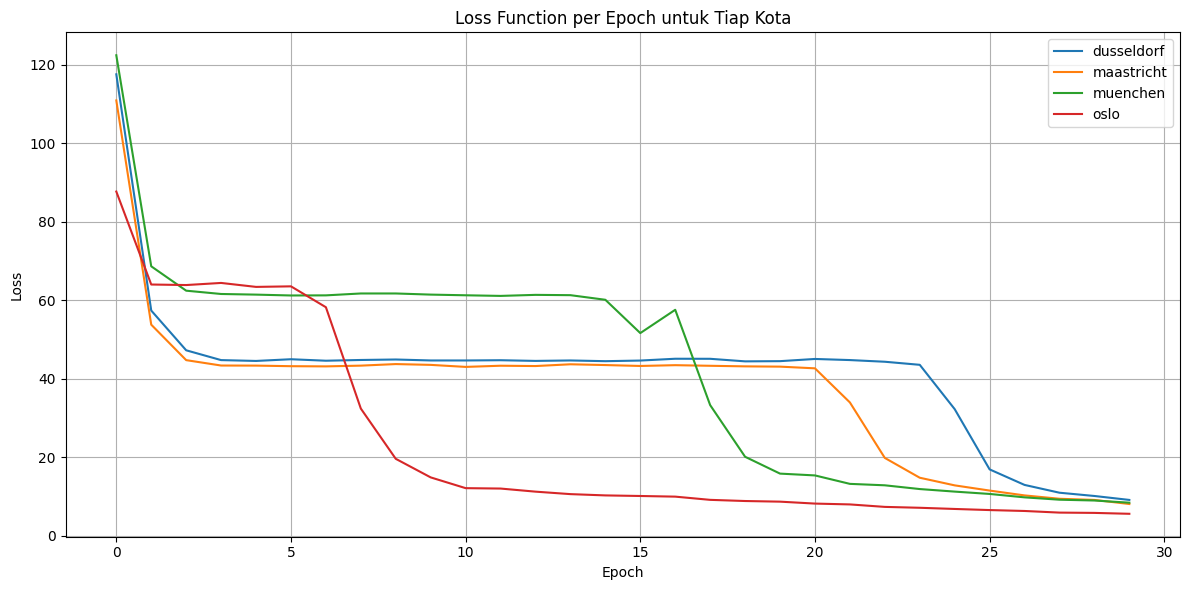

In [ ]:
import torch
import matplotlib.pyplot as plt

# Config
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dictionary untuk menyimpan history loss tiap kota
loss_history = {}

# Training Loop
for kota in kota_list:
    model = data_per_kota[kota]['model'].to(device)
    criterion = data_per_kota[kota]['criterion']
    optimizer = data_per_kota[kota]['optimizer']
    train_loader = data_per_kota[kota]['train_loader']

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).unsqueeze(1)

            # Forward
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Simpan loss untuk kota ini
        if kota not in loss_history:
            loss_history[kota] = []
        loss_history[kota].append(epoch_loss / len(train_loader))

        # Print progress
        print(f"[{kota.upper()}] Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss/len(train_loader):.4f}")

# Visualisasi Loss
plt.figure(figsize=(12, 6))
for kota in kota_list:
    plt.plot(loss_history[kota], label=kota)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Function per Epoch untuk Tiap Kota')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for kota in kota_list:
    print(f"Evaluasi model untuk kota: {kota.upper()}")

    model = data_per_kota[kota]['model'].to(device)
    test_loader = data_per_kota[kota]['test_loader']

    model.eval()  # mode evaluasi

    y_true_all = []
    y_pred_all = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).unsqueeze(1)

            y_pred = model(X_batch)

            y_true_all.extend(y_batch.cpu().numpy())
            y_pred_all.extend(y_pred.cpu().numpy())

    mse = mean_squared_error(y_true_all, y_pred_all)
    mae = mean_absolute_error(y_true_all, y_pred_all)

    print(f"[{kota.upper()}] Test MSE: {mse:.4f}, MAE: {mae:.4f}\n")

Evaluasi model untuk kota: DUSSELDORF
[DUSSELDORF] Test MSE: 10.3093, MAE: 2.5576

Evaluasi model untuk kota: MAASTRICHT
[MAASTRICHT] Test MSE: 7.6555, MAE: 2.1879

Evaluasi model untuk kota: MUENCHEN
[MUENCHEN] Test MSE: 8.8389, MAE: 2.4191

Evaluasi model untuk kota: OSLO
[OSLO] Test MSE: 5.4465, MAE: 1.7915



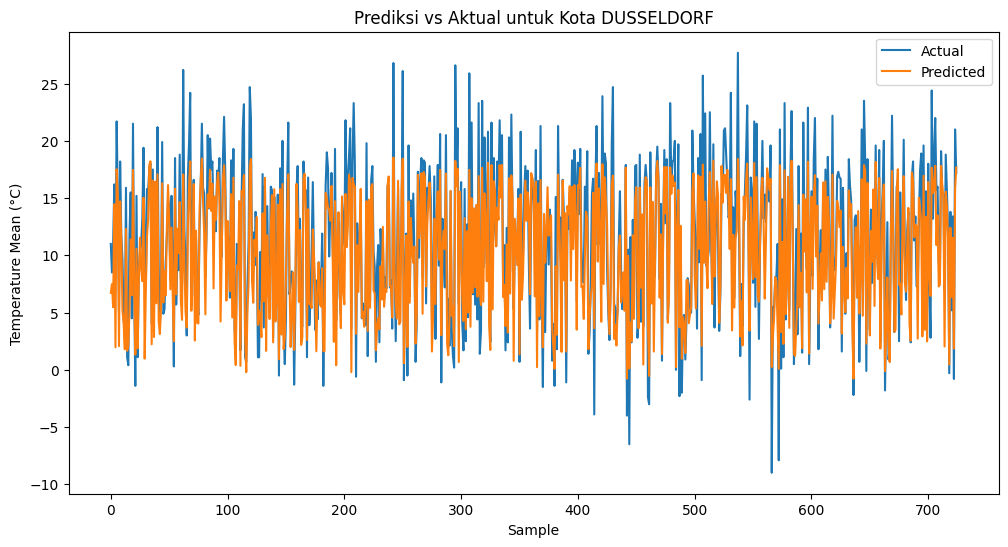

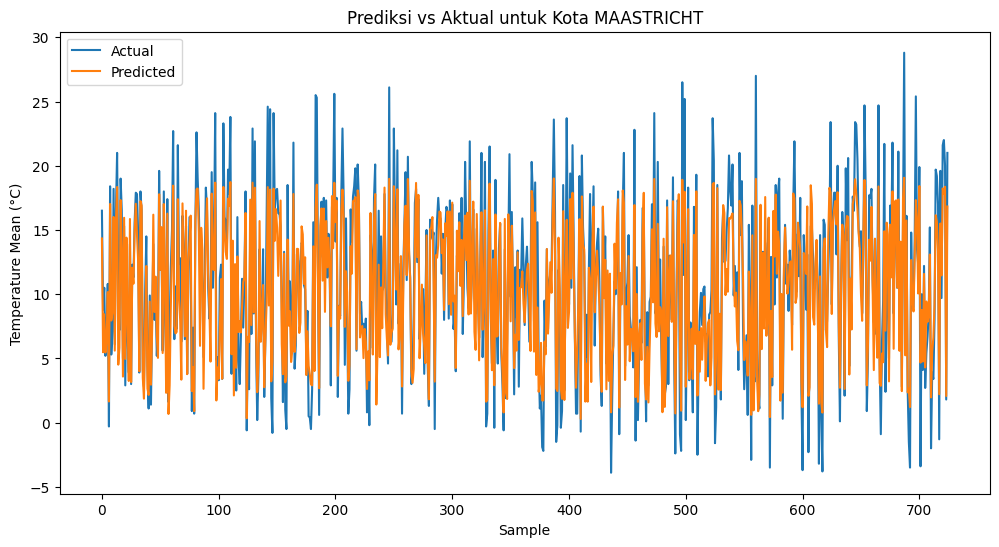

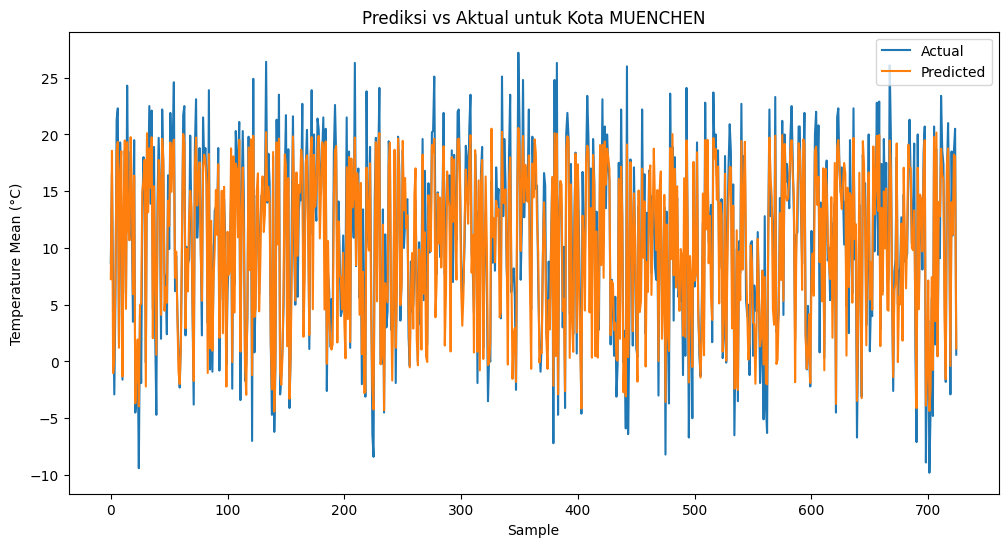

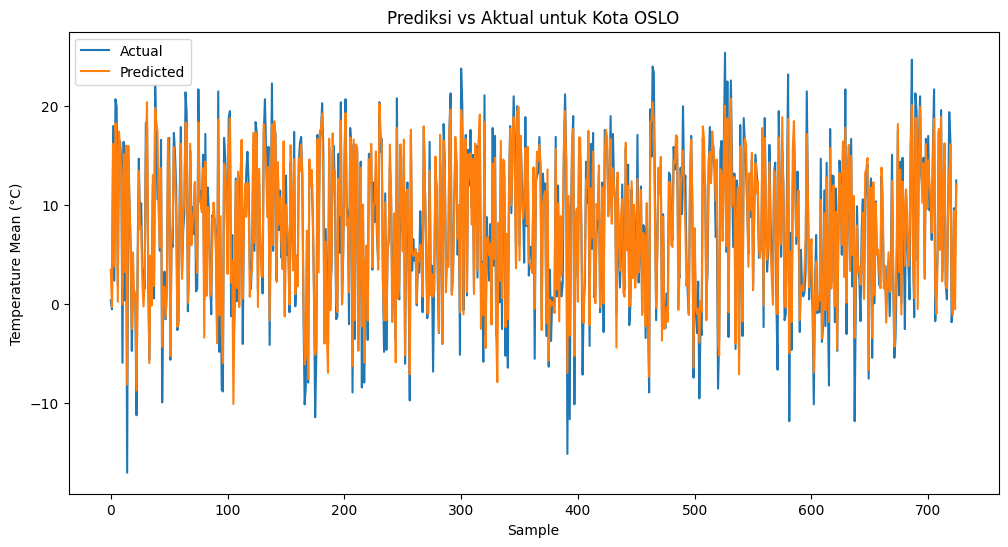

In [ ]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot_predictions(model, data_loader, kota, scaler, window_size=30):
    model.eval()
    preds = []
    actuals = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch).cpu().numpy()
            preds.extend(y_pred.flatten())
            actuals.extend(y_batch.numpy().flatten())

    # Jika target dinormalisasi, lakukan inverse transformasi ke skala asli
    # Karena kita hanya men-scaler fitur, kita butuh cara khusus jika target juga di-scale
    # Misal, jika target adalah fitur ke-n, lakukan inverse pada kolom target ini saja
    # Kalau tidak, pastikan target y_tensor sudah pada skala asli

    plt.figure(figsize=(12,6))
    plt.plot(actuals, label='Actual')
    plt.plot(preds, label='Predicted')
    plt.title(f'Prediksi vs Aktual untuk Kota {kota.upper()}')
    plt.xlabel('Sample')
    plt.ylabel('Temperature Mean (°C)')
    plt.legend()
    plt.show()

# Contoh pemanggilan visualisasi untuk tiap kota
for kota in kota_list:
    model = data_per_kota[kota]['model'].to(device)
    test_loader = data_per_kota[kota]['test_loader']
    scaler = data_per_kota[kota]['scaler']  # Jika kamu scaling fitur, target mungkin tidak diskalakan

    plot_predictions(model, test_loader, kota, scaler)


# **Klasifikasi SVM**

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import torch

# Step 1: Baca file label dan konversi DATE
df_labels = pd.read_csv("weather_prediction_bbq_labels.csv")  # ubah path jika perlu
df_labels['DATE'] = pd.to_datetime(df_labels['DATE'].astype(str), format='%Y%m%d')


In [ ]:
label_cols = ['DUSSELDORF_BBQ_weather', 'MAASTRICHT_BBQ_weather', 'MUENCHEN_BBQ_weather', 'OSLO_BBQ_weather']
label_encoder = LabelEncoder()
for col in label_cols:
    df_labels[col] = label_encoder.fit_transform(df_labels[col])

In [ ]:
df_labels

,DATE,BASEL_BBQ_weather,BUDAPEST_BBQ_weather,DE_BBQ_weather,DRESDEN_BBQ_weather,DUSSELDORF_BBQ_weather,HEATHROW_BBQ_weather,KASSEL_BBQ_weather,LJUBLJANA_BBQ_weather,MAASTRICHT_BBQ_weather,MALMO_BBQ_weather,MONTELIMAR_BBQ_weather,MUENCHEN_BBQ_weather,OSLO_BBQ_weather,PERPIGNAN_BBQ_weather,SONNBLICK_BBQ_weather,STOCKHOLM_BBQ_weather,TOURS_BBQ_weather
0,2000-01-01,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False
1,2000-01-02,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False
2,2000-01-03,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False
3,2000-01-04,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False
4,2000-01-05,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,2009-12-28,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False
3650,2009-12-29,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False
3651,2009-12-30,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False
3652,2009-12-31,False,False,False,False,0,False,False,False,0,False,False,0,0,False,False,False,False


In [ ]:
# Step 3: Loop tiap kota dan siapkan hasil prediksi LSTM
svm_reports = {}

for kota in ['dusseldorf', 'maastricht', 'muenchen', 'oslo']:
    label_col = f"{kota.upper()}_BBQ_weather"

    # Ambil hasil prediksi dari model LSTM
    model = data_per_kota[kota]['model'].to('cpu')
    X_tensor = data_per_kota[kota]['X_tensor']

    # Ambil tanggal dan buat windowed agar sejajar dengan prediksi
    dates = pd.to_datetime(data_per_kota[kota]['DATE'].reset_index(drop=True), format='%Y%m%d')
    windowed_dates = dates[window_size:].reset_index(drop=True)

    # Prediksi temperatur rata-rata
    model.eval()
    with torch.no_grad():
        preds = model(X_tensor).squeeze().numpy()

    # Buat DataFrame prediksi
    df_preds = pd.DataFrame({
        'DATE': windowed_dates,
        'predicted_tempmean': preds
    })

    # Gabungkan dengan label BBQ
    print(f"Shape of df_preds for {kota}: {df_preds.shape}")
    print(f"Shape of df_labels for {kota}: {df_labels[['DATE', label_col]].shape}")
    df_merge = df_preds.merge(df_labels[['DATE', label_col]], on='DATE', how='inner')
    print(f"Shape of merged df for {kota}: {df_merge.shape}")


    # Siapkan data untuk SVM
    X = df_merge[['predicted_tempmean']].values
    y = df_merge[label_col].values

    # Split manual: 80% train, 20% test
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Latih SVM dan evaluasi
    clf = SVC(kernel='rbf', C=1.0, gamma='scale')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Simpan hasil evaluasi
    report = classification_report(y_test, y_pred, target_names=['Tidak BBQ', 'BBQ'], output_dict=True)
    svm_reports[kota] = {
        "report": report,
        "y_test": y_test,
        "y_pred": y_pred
    }

# Tampilkan ringkasan hasil
for kota, result in svm_reports.items():
    print(f"\n=== Klasifikasi SVM untuk {kota.upper()} ===")
    print(classification_report(result['y_test'], result['y_pred'], target_names=['Tidak BBQ', 'BBQ']))

Shape of df_preds for dusseldorf: (3624, 2)
Shape of df_labels for dusseldorf: (3654, 2)
Shape of merged df for dusseldorf: (3624, 3)
Shape of df_preds for maastricht: (3624, 2)
Shape of df_labels for maastricht: (3654, 2)
Shape of merged df for maastricht: (3624, 3)
Shape of df_preds for muenchen: (3624, 2)
Shape of df_labels for muenchen: (3654, 2)
Shape of merged df for muenchen: (3624, 3)
Shape of df_preds for oslo: (3624, 2)
Shape of df_labels for oslo: (3654, 2)
Shape of merged df for oslo: (3624, 3)

=== Klasifikasi SVM untuk DUSSELDORF ===
              precision    recall  f1-score   support

   Tidak BBQ       0.82      0.90      0.86       564
         BBQ       0.48      0.31      0.38       161

    accuracy                           0.77       725
   macro avg       0.65      0.61      0.62       725
weighted avg       0.75      0.77      0.75       725


=== Klasifikasi SVM untuk MAASTRICHT ===
              precision    recall  f1-score   support

   Tidak BBQ       0.8